In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

import itertools
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from skimage.segmentation import watershed, slic
from skimage.filters import sobel
from sklearn.cluster import BisectingKMeans, KMeans
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D
from population import unit_response_matrix, activity_at_phase

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [11]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

# 009266
# sessions = [s for s in selected_009266.keys()]
# sessions.sort()
# selected = sessions[:]


# 009265
# sessions = [s for s in selected_009265.keys()]
# sessions.sort()
# selected = sessions[:]
# selected.remove('009265_hippoSIT_2023-02-27_10-18-32')
# selected.remove('009265_hippoSIT_2023-02-27_15-33-46')
# selected = selected[7:-1]

# animal 57
# selected1 = [
# #    "57_SIT_2023-12-21_15-05-52",
#     "57_SIT_2023-12-22_14-08-07",
#     "57_SIT_2023-12-22_17-37-18",
#     "57_SIT_2023-12-28_16-43-28",
#     "57_SIT_2023-12-29_11-06-26",
#     "57_SIT_2023-12-29_11-40-14",
#     "57_SIT_2024-01-02_16-38-05",
#     "57_SIT_2024-01-02_17-10-09",
#     "57_SIT_2024-01-03_19-54-59",
# ]

# selected = [
#     "57_SIT_2023-12-18_14-07-34",
#     "57_SIT_2023-12-19_14-15-26",
#     "57_SIT_2023-12-22_14-08-07",
#     "57_SIT_2023-12-22_14-43-58",
#     "57_SIT_2023-12-22_17-37-18",
#     "57_SIT_2023-12-23_14-21-01",
#     "57_SIT_2023-12-28_16-43-28",
#     "57_SIT_2023-12-29_11-06-26",
#     "57_SIT_2023-12-29_11-40-14",
#     "57_SIT_2023-12-29_12-11-46",
#     "57_SIT_2024-01-02_14-43-18",
#     "57_SIT_2024-01-02_16-38-05",
#     "57_SIT_2024-01-02_17-10-09",
#     "57_SIT_2024-01-03_19-22-18",
#     "57_SIT_2024-01-03_19-54-59",
#     "57_SIT_2024-01-04_14-16-22",
#     "57_SIT_2024-01-04_14-52-59",
#     "57_SIT_2024-01-05_14-35-49",
#     "57_SIT_2024-01-05_15-08-34",
#     "57_SIT_2024-01-06_16-52-40",
#     "57_SIT_2024-01-06_17-25-35",
#     "57_SIT_2024-01-07_19-23-28",
#     "57_SIT_2024-01-08_15-51-26",
#     "57_SIT_2024-01-12_13-23-02",
#     "57_SIT_2024-01-15_13-45-22",
#     "57_SIT_2024-01-15_14-34-48"
# ]

# showcase
selected = [
    '009266_hippoSIT_2023-05-04_19-47-15',
    '009266_hippoSIT_2023-04-17_17-04-17',
    '009266_hippoSIT_2023-05-23_09-18-05',
    '009266_hippoSIT_2023-04-20_08-57-39'
]
# selected = [
#     "60_SIT_2023-09-26_19-10-17",
#     "60_SIT_2023-09-28_09-55-55"
# ]

# showcase for Fig. 5
# selected = [
#     '009265_hippoSIT_2023-03-09_20-03-08',
#     '009266_hippoSIT_2023-04-17_17-04-17',
#     '009266_hippoSIT_2023-04-18_10-10-37',
#     '009266_hippoSIT_2023-04-20_08-57-39',
#     '009266_hippoSIT_2023-04-24_10-08-11',
#     '009266_hippoSIT_2023-04-26_08-20-17',
#     '009266_hippoSIT_2023-05-02_12-22-14',
#     '009266_hippoSIT_2023-05-04_19-47-15',
#     '009266_hippoSIT_2023-05-23_09-18-05',
#     '009265_hippoSIT_2023-03-03_09-37-07',
#     '009265_hippoSIT_2023-03-04_11-12-04',
#     '009265_hippoSIT_2023-03-05_11-52-17',
# ]

selected

['009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-04-20_08-57-39']

In [12]:
ft = 'tSNE'
fp = 70
#ft = 'UMAP'
#fp = '0.7'
speed_thresh = 0.04  # m/s
sound_state = 'BGR'
margin = 5
sigma = 0.1
bin_count = 100

## Precomputed

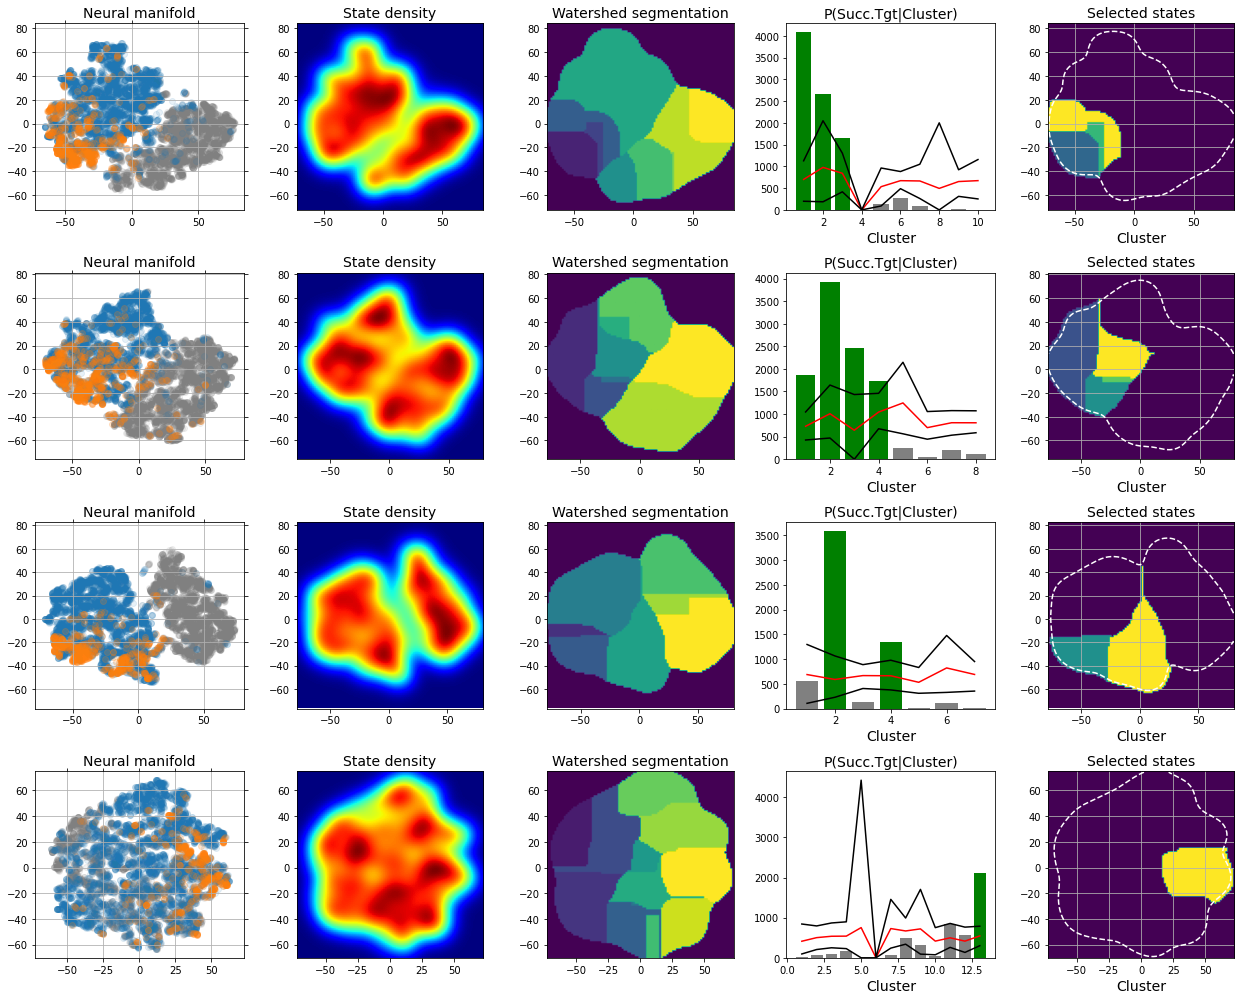

In [14]:
size = 3.5
cols = 5
fig, axes = plt.subplots(len(selected), cols, figsize=(cols*size, size*len(selected)))

for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    nMAP_seg_file = os.path.join(source, animal, session, 'analysis', 'nMAP_segmentation.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(umap_file, 'r') as f:
        fit = np.array(f[ft][str(fp)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    with h5py.File(nMAP_seg_file, 'r') as f:
        d_map = np.array(f['density_map'])
        segmentation = np.array(f['segmentation'])
        segmentation_TGT_succ = np.array(f['segmentation_TGT_succ'])
        idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])
        tgt_stats = np.array(f['tgt_stats'])
        tgt_stats_shuf = np.array(f['tgt_stats_shuf'])

    # auditory state (BGR, SIL etc.) and speed filter
    idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]
    idxs_tri_ev = np.where( (events[:, 1] == 1) | (events[:, 1] == 2) )[0]  # in the trial
    
    idxs_succ_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_succ_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_succ_ev = np.array(idxs_succ_ev)
    
    # extent and contour
    extent = get_extent(fit, margin=margin)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    nMAP_cont = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    axes[i][0].clear()
    
    # Scatter
    ax = axes[i][0]
    ax.scatter(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1], alpha=0.1, color='gray')
    ax.scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], alpha=0.1, color='tab:blue')
    ax.scatter(fit[idxs_succ_ev][:, 0], fit[idxs_succ_ev][:, 1], alpha=0.2, color='tab:orange')
    #ax.scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], alpha=0.1, color='gray')
    #ax.scatter(fit[idxs_succ_ev][:, 0], fit[idxs_succ_ev][:, 1], alpha=0.1, color='gray')
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.grid()
    ax.set_title('Neural manifold', fontsize=14)
    
    # density
    ax = axes[i][1]
    ax.imshow(d_map.T, cmap='jet', origin='lower', extent=extent)
    ax.set_title('State density', fontsize=14)

    # watershed
    ax = axes[i][2]
    ax.imshow(segmentation.T, origin='lower', extent=extent)
    ax.set_title('Watershed segmentation', fontsize=14)

    # mean and percentiles by cluster
    labels = np.unique(segmentation)[1:]
    tgt_stats_shuf_mean = tgt_stats_shuf.mean(axis=0)
    confidence_low  = np.zeros(tgt_stats_shuf.shape[1])
    confidence_high = np.zeros(tgt_stats_shuf.shape[1])
    for k, col in enumerate(tgt_stats_shuf.T):
        confidence_low[k]  = np.percentile(col, 5)
        confidence_high[k] = np.percentile(col, 95)
        
    idxs_tgt_stats_low  = tgt_stats < confidence_high
    idxs_tgt_stats_high = tgt_stats > confidence_high
    
    ax = axes[i][3]
    ax.bar(labels[idxs_tgt_stats_low], tgt_stats[idxs_tgt_stats_low], color='gray')
    ax.bar(labels[idxs_tgt_stats_high], tgt_stats[idxs_tgt_stats_high], color='green')
    ax.plot(labels, tgt_stats_shuf.mean(axis=0), color='red')
    ax.plot(labels, confidence_low, color='black')
    ax.plot(labels, confidence_high, color='black')
    ax.set_title('P(Succ.Tgt|Cluster)', fontsize=14)
    ax.set_xlabel('Cluster', fontsize=14)
        
    # seleted areas by TGT
    ax = axes[i][4]
    ax.imshow(segmentation_TGT_succ.T, origin='lower', extent=extent)
    #ax.scatter(fit[idxs_tgt_succ_state_ev][:, 0], fit[idxs_tgt_succ_state_ev][:, 1], alpha=0.2)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.grid()
    ax.set_title('Selected states', fontsize=14)
    ax.set_xlabel('Cluster', fontsize=14)
    
    # contour
    for path in nMAP_cont.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='white', ls='--')
    
fig.tight_layout()

In [76]:
fig.savefig(os.path.join(report, 'population', 'nMAP_segmentation_%s_sel.png' % animal), dpi=300)

## Playground

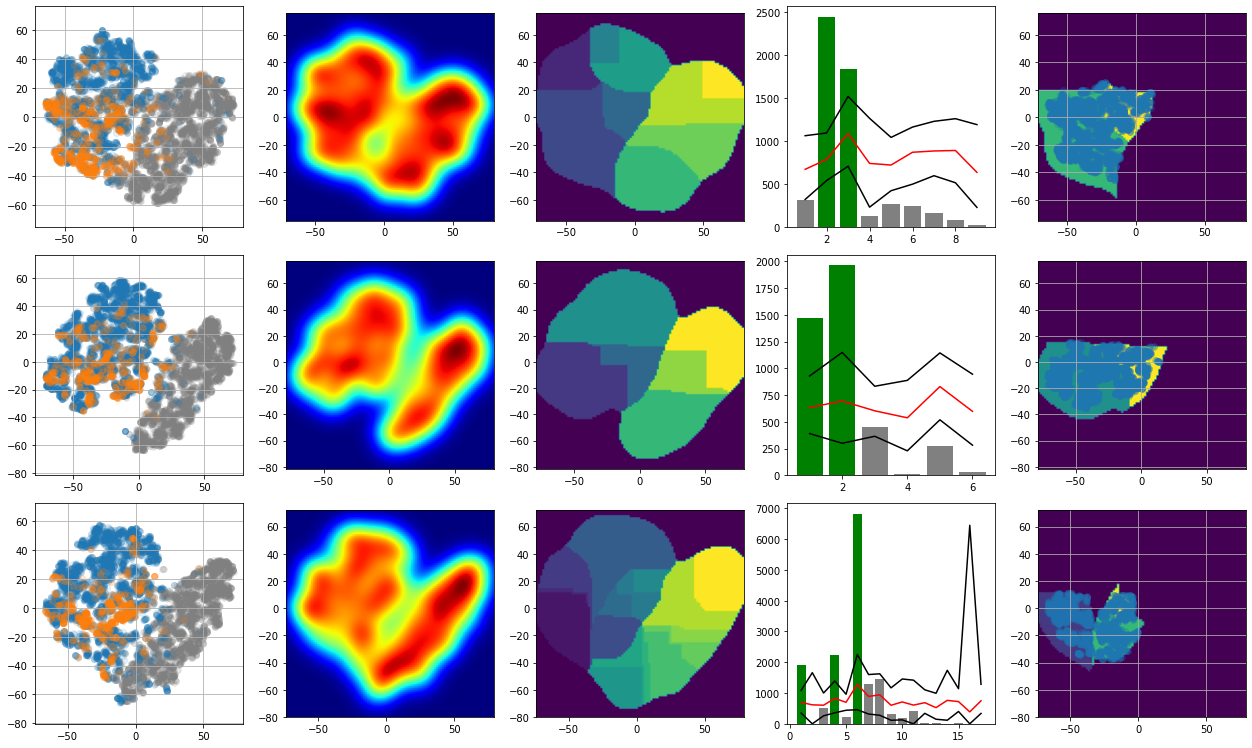

In [20]:
size = 3.5
cols = 5
fig, axes = plt.subplots(len(selected), cols, figsize=(cols*size, size*len(selected)))

for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file  = os.path.join(source, animal, session, 'analysis', 'W1-W4_tSNE_UMAP.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(umap_file, 'r') as f:
        fit = np.array(f[ft][str(fp)])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        b_fit = np.array(f[ft][str(fp)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])

    # auditory state (BGR, SIL etc.) and speed filter
    idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]
    idxs_tri_ev = np.where( (events[:, 1] == 1) | (events[:, 1] == 2) )[0]  # in the trial
    
    idxs_succ_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_succ_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_succ_ev = np.array(idxs_succ_ev)
    
    # Scatter
    extent = get_extent(fit, margin=margin)
    
    ax = axes[i][0]
    ax.scatter(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1], alpha=0.1, color='gray')
    ax.scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], alpha=0.1, color='tab:blue')
    ax.scatter(fit[idxs_succ_ev][:, 0], fit[idxs_succ_ev][:, 1], alpha=0.2, color='tab:orange')
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.grid()
    
    # density
    d_map  = density_map(fit, extent, sigma=sigma, bin_count=100)
    ax = axes[i][1]
    ax.imshow(d_map.T, cmap='jet', origin='lower', extent=extent)

    # watershed
    mask = d_map > 0.1*d_map.max()
    fit_labels = watershed(-d_map, mask=mask)
    
    ax = axes[i][2]
    ax.imshow(fit_labels.T, origin='lower', extent=extent)

    # using k-means
#     algo = KMeans(n_clusters=10, random_state=0)
#     algo.fit(fit)
#     centers = algo.cluster_centers_
#     ax.scatter(fit[:, 0], fit[:, 1], s=10, c=algo.labels_)
#     ax.scatter(centers[:, 0], centers[:, 1], c="r", s=20)

    
    # TGT cluster stats
    labels = np.unique(fit_labels)[1:]
    fit_area = (fit_labels > 0).sum()
    label_areas = [(fit_labels == x).sum()/fit_area for x in labels]
    clu_tgt_counts = np.zeros(len(labels))
    x_bins = np.linspace(extent[0], extent[1], fit_labels.shape[0]+1)
    y_bins = np.linspace(extent[2], extent[3], fit_labels.shape[1]+1)

    # collecting label counts
    for record in fit[idxs_succ_ev]:
        x_bin_idx = np.where(x_bins > record[0])[0][0] - 1
        y_bin_idx = np.where(y_bins > record[1])[0][0] - 1

        curr_label = fit_labels[x_bin_idx, y_bin_idx]
        clu_tgt_counts[curr_label-1] += 1
    tgt_stats = clu_tgt_counts/label_areas

    # shuffle TGT and conf intervals
    iter_count = 100
    tgt_stats_shuf = np.zeros([iter_count, len(labels)])
    tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
    for k in range(iter_count):
        clu_tgt_counts = np.zeros(len(labels))
        
        tgt_mx_succ_shuf = tgt_mx_succ.copy()
        rand_shift = np.random.randint(len(tl))
        tgt_mx_succ_shuf[:, 0] = np.mod(tgt_mx_succ[:, 0] + rand_shift, len(events))
        tgt_mx_succ_shuf[:, 1] = np.mod(tgt_mx_succ[:, 1] + rand_shift, len(events))

        idxs_succ_shuf_ev = []
        for tgt_rec in tgt_mx_succ_shuf:
            idxs_succ_shuf_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))

        for record in fit[idxs_succ_shuf_ev]:
            x_bin_idx = np.where(x_bins > record[0])[0][0] - 1
            y_bin_idx = np.where(y_bins > record[1])[0][0] - 1

            curr_label = fit_labels[x_bin_idx, y_bin_idx]
            clu_tgt_counts[curr_label-1] += 1
        tgt_stats_shuf[k] = clu_tgt_counts/label_areas

    # mean and percentiles by cluster
    tgt_stats_shuf_mean = tgt_stats_shuf.mean(axis=0)
    confidence_low  = np.zeros(tgt_stats_shuf.shape[1])
    confidence_high = np.zeros(tgt_stats_shuf.shape[1])
    for k, col in enumerate(tgt_stats_shuf.T):
        confidence_low[k]  = np.percentile(col, 5)
        confidence_high[k] = np.percentile(col, 95)
        
    idxs_tgt_stats_low  = tgt_stats < confidence_high
    idxs_tgt_stats_high = tgt_stats > confidence_high
    
    ax = axes[i][3]
    ax.bar(labels[idxs_tgt_stats_low], tgt_stats[idxs_tgt_stats_low], color='gray')
    ax.bar(labels[idxs_tgt_stats_high], tgt_stats[idxs_tgt_stats_high], color='green')
    ax.plot(labels, tgt_stats_shuf.mean(axis=0), color='red')
    ax.plot(labels, confidence_low, color='black')
    ax.plot(labels, confidence_high, color='black')
        
    # seleted areas by TGT
    labels_sel = labels[idxs_tgt_stats_high]
    fit_labels_sel = fit_labels.copy()
    for label in labels:
        if not label in labels_sel:
            idxs_x = np.where(fit_labels_sel == label)[0]
            idxs_y = np.where(fit_labels_sel == label)[1]
            for x, y in np.column_stack([idxs_x, idxs_y]):
                fit_labels_sel[x][y] = 0
    ax = axes[i][4]
    ax.imshow(fit_labels_sel.T, origin='lower', extent=extent)
    
    # or, detect fit indices
    idxs_tgt_n_state = get_idxs_in_patches(fit, fit_labels_sel, extent, bin_count=bin_count)
    ax.scatter(fit[idxs_tgt_n_state][:, 0], fit[idxs_tgt_n_state][:, 1], alpha=0.2)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.grid()
    
    
    
fig.tight_layout()